### Forgery exposure CNN model - with use of Transfer Learning

In [0]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!pip install numpy==1.16.1

# This version of numpy is necessary for loading the np file which holds the pictures of signatures that will be used for modelling

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random as rn

import pathlib

from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import losses, optimizers
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection

import os
import time

%matplotlib inline

import cv2

from google.colab.patches import cv2_imshow

import h5py

from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [0]:
# Setting up some random seeds
np.random.seed(7)
rn.seed(12345)
tf.set_random_seed(1234)

In [0]:
csv_fajl_1 = pd.read_csv("./drive/My Drive/signature-data/all signatures with flags preimenovani.csv")
y = csv_fajl_1["flag_if_forge"]
csv_fajl_1.head()

,signatures,flag_if_forge
0,014_forg/01_0102014.png,1
1,014_forg/02_0102014.png,1
2,014_forg/03_0102014.png,1
3,014_forg/04_0102014.png,1
4,004_forg/02_0103004.png,1


In [0]:
# Loading the np file that holds the pictures
dataset_old = np.load('./drive/My Drive/signature-data/dataset_np.npy')

In [0]:
nr_pictures = len(dataset_old)
nr_pictures

1649

In [0]:
HEIGHT = 244
WIDTH = 244

In [0]:
dataset_resized = np.repeat(0, HEIGHT*WIDTH*nr_pictures*3)
dataset_resized = np.reshape(dataset_resized, (nr_pictures, HEIGHT, WIDTH, 3))

In [0]:
dataset_resized.shape

(1649, 244, 244, 3)

In [0]:
#Resizing the pictures to 244x244

for i,image in enumerate(dataset_old):
  dataset_resized[i] = cv2.resize(image, (WIDTH,HEIGHT))

In [0]:
dataset_old = []

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_resized, y, test_size=0.1, random_state=42, stratify=y)

In [0]:
dataset_resized = []

In [0]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.111, random_state=42, stratify=y_train)

In [0]:
# Preprocessing

# Since this is the version with using Transfer Learning, we use the input preprocessing from VGG16

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
X_test = preprocess_input(X_test)

In [0]:
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print()
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)
print()
print("X val shape: ", X_val.shape)
print("y val shape: ", y_val.shape)

X train shape:  (1319, 244, 244, 3)
y train shape:  (1319,)

X test shape:  (165, 244, 244, 3)
y test shape:  (165,)

X val shape:  (165, 244, 244, 3)
y val shape:  (165,)


In [0]:
# One hot encoding

def one_hot(y, C):
  y_one_hot = np.zeros((y.shape[0], C))
  y_one_hot[np.arange(0, y.shape[0]), y] = 1
    
  return y_one_hot

In [0]:
# Number of categories
C = 2

In [0]:
# Encoding the targets
y1_train = one_hot(y_train, C)
y1_test = one_hot(y_test, C)
y1_val = one_hot(y_val, C)

In [0]:
print("y train shape: ", y1_train.shape)
print()
print("y test shape: ", y1_test.shape)
print()
print("y val shape: ", y1_val.shape)

y train shape:  (1319, 2)

y test shape:  (165, 2)

y val shape:  (165, 2)


In [0]:
#input_shape = X_train.shape[1:]
#input_shape

In [0]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(244,244,3))

In [0]:
# Making all the layers from VGG16 non-trainable!
for layer in base_model.layers:
  layer.trainable = False

  
# Building our model on top of VGG16, since we removed its top layer
# Final model architecture:
x_input = base_model.output
x = Flatten()(x_input)
x = Dropout(0.3)(x)
x = Dense(4096, activation="relu", kernel_regularizer=l2(2e-3))(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation="relu", kernel_regularizer=l2(2e-3))(x)
preds = Dense(C, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=preds)

In [0]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0   

In [0]:
model.compile(optimizer=SGD(nesterov=True, lr=0.0005) , loss="binary_crossentropy", metrics=["acc"])

In [0]:
epochs = 20
batch_size = 32
verbose = 1

model_num = "102-nestor-c"

checkpoints_path = './drive/My Drive/checkpoints/sign/'+'checkpoint-'+model_num+'-epoch-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoints_path1 = './drive/My Drive/checkpoints/sign/'+'checkpoint-'+model_num+'-history.txt'

callbacks = [EarlyStopping(monitor='acc', 
                           min_delta = 0, 
                           patience = 3, 
                           mode = 'auto'),
            ModelCheckpoint(filepath=checkpoints_path,
                           verbose = verbose)]


t=time.time()

In [0]:
history = model.fit(X_train,
                    y1_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    callbacks=callbacks,
                    validation_data = (X_val,y1_val))

    
print('Training time: %s' % (time.time()-t))

Train on 1319 samples, validate on 165 samples
Epoch 1/20
1319/1319 [==============================] - 942s 714ms/step - loss: 26.7256 - acc: 0.6020 - val_loss: 24.8299 - val_acc: 0.6970

Epoch 00001: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-102-nestor-c-epoch-01-0.70.hdf5
Epoch 2/20
1319/1319 [==============================] - 942s 714ms/step - loss: 24.1691 - acc: 0.7559 - val_loss: 22.9777 - val_acc: 0.8788

Epoch 00002: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-102-nestor-c-epoch-02-0.88.hdf5
Epoch 3/20
1319/1319 [==============================] - 941s 713ms/step - loss: 23.4103 - acc: 0.8340 - val_loss: 23.3046 - val_acc: 0.8667

Epoch 00003: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-102-nestor-c-epoch-03-0.87.hdf5
Epoch 4/20
1319/1319 [==============================] - 941s 714ms/step - loss: 22.7521 - acc: 0.9030 - val_loss: 23.8303 - val_acc: 0.7879

Epoch 00004: saving model to ./drive/My Drive/checkpoints/sign/checkpoi

In [0]:
#Saving the model history pn Google Drive
f = open(checkpoints_path1, "w")
f.write( str(history.history) )
f.close()

In [0]:
val_acc_hist = history.history["val_acc"]
val_loss_hist = history.history["val_loss"]
train_acc_hist = history.history["acc"]
train_loss_hist = history.history["loss"]
epochs = history.epoch

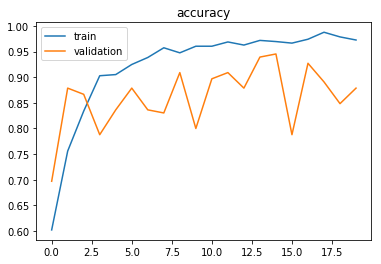

In [0]:
plt.title("accuracy")
plt.plot(epochs, train_acc_hist, label="train")
plt.plot(epochs, val_acc_hist, label = "validation")
plt.legend()

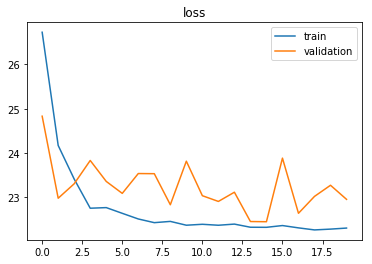

In [0]:
plt.title("loss")
plt.plot(epochs, train_loss_hist, label="train")
plt.plot(epochs, val_loss_hist, label = "validation")
plt.legend()

In [0]:
# From the graph, we can see that at epoch 15 accuracy starts its decreasing trend, and loss its increasing trend
# So I chose to train the model on 15 epochs and use it as a final model

In [0]:
# training on train + val set

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(244,244,3))

# Making all the layers from VGG16 non-trainable!
for layer in base_model.layers:
  layer.trainable = False

x_input = base_model.output
x = Flatten()(x_input)
x = Dropout(0.3)(x)
x = Dense(4096, activation="relu", kernel_regularizer=l2(2e-3))(x) # 
x = Dropout(0.3)(x)
x = Dense(4096, activation="relu", kernel_regularizer=l2(2e-3))(x) # 
#x = Dropout(0.5)(x)
preds = Dense(C, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=preds)




model.compile(optimizer=SGD(nesterov=True, lr=0.0005) , loss="binary_crossentropy", metrics=["acc"])

In [0]:
dataset_old = np.load('./drive/My Drive/signature-data/dataset_np.npy')

In [0]:
dataset_resized = np.repeat(0, HEIGHT*WIDTH*nr_pictures*3)
dataset_resized = np.reshape(dataset_resized, (nr_pictures, HEIGHT, WIDTH, 3))

In [0]:
for i,image in enumerate(dataset_old):
  dataset_resized[i] = cv2.resize(image, (WIDTH,HEIGHT))

In [0]:
dataset_old = []

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_resized, y, test_size=0.1, random_state=42, stratify=y)

In [0]:
dataset_resized = []

In [0]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

y1_train = one_hot(y_train, C)
y1_test = one_hot(y_test, C)

In [0]:
epochs = 15
batch_size = 32
verbose = 1

checkpoints_path = './drive/My Drive/checkpoints/sign/checkpoint-final-tl-epoch-{epoch:02d}.hdf5'
checkpoints_path1 = './drive/My Drive/checkpoints/sign/checkpoint-final-tl-history.txt'

callbacks = [EarlyStopping(monitor='acc', 
                           min_delta = 0, 
                           patience = 3, 
                           mode = 'auto'),
            ModelCheckpoint(filepath=checkpoints_path,
                           verbose = verbose)]


t=time.time()

In [0]:
history = model.fit(X_train,
                    y1_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    callbacks=callbacks)

    
print('Training time: %s' % (time.time()-t))

Epoch 1/15
1484/1484 [==============================] - 937s 631ms/step - loss: 27.4120 - acc: 0.5748

Epoch 00001: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-tl-epoch-01.hdf5
Epoch 2/15
1484/1484 [==============================] - 932s 628ms/step - loss: 24.1593 - acc: 0.7642

Epoch 00002: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-tl-epoch-02.hdf5
Epoch 3/15
1484/1484 [==============================] - 934s 629ms/step - loss: 23.4360 - acc: 0.8248

Epoch 00003: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-tl-epoch-03.hdf5
Epoch 4/15
1484/1484 [==============================] - 931s 627ms/step - loss: 22.7462 - acc: 0.9104

Epoch 00004: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-tl-epoch-04.hdf5
Epoch 5/15
1484/1484 [==============================] - 931s 628ms/step - loss: 22.7103 - acc: 0.9158

Epoch 00005: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-tl-epoch-05.hdf5


In [0]:
# genuine = positive -> 0
# forged = negative -> 1

# False Acceptance Rate
def FAR_acc(y, y_pred):
  FN = sum((y == 0) & (y_pred == 1))
  TP = sum((y == 0) & (y_pred == 0))
  return(FN / (FN + TP))


# False Rejection Rate
def FRR_acc(y, y_pred):
  FP = sum((y == 1) & (y_pred == 0))
  TN =  sum((y == 1) & (y_pred == 1))
  return(FP / (FP + TN))


# Both values should be as lower as possible, but with accent on FAR

In [0]:
def one_hot_decode(matrix):
  return np.array([list(row).index(1) for row in matrix])

In [0]:
def preds_decode(matrix):
  result = []
  for row in matrix:
    if row[0]>0.5:
      result.append(0)
    else: result.append(1)
  return np.array(result)

In [0]:
# TEST SET
test_loss, test_acc = model.evaluate(X_test, y1_test)

y_pred_test = model.predict(X_test)
y_pred_test_1 = preds_decode(y_pred_test)

test_FAR = FAR_acc(y_test, y_pred_test_1)
test_FRR = FRR_acc(y_test, y_pred_test_1)

165/165 [==============================] - 99s 597ms/step


In [0]:
print("Test Accuracy", test_acc)
print("Test FAR", test_FAR)
print("Test FRR", test_FRR)

Test Accuracy 0.9515151518763918
Test FAR 0.056179775280898875
Test FRR 0.039473684210526314


In [0]:
# Final results.